Cristobal Alcaino


In [3]:
import pandas as pd
df_sc = pd.read_excel("BBDD/SC_COTIZACIONES.xlsx")
print(df_sc.head())

  FECHA_COTIZACION  NUMERO_SOLICITUD  NUMERO_IDENTIFICACION  NUMERO_SECUENCIA  \
0       2024-01-02         125720401              188965131                 1   
1       2024-01-02         125720401              188965150                 1   
2       2024-01-02         125720401              188965169                 1   
3       2024-01-02         125720401              188965188                 1   
4       2024-01-02         125747401              188975930                 1   

  TIPO_RENTA  MESES_DIFERIDOS MODALIDAD_RENTA  MESES_GARANTIZADOS  \
0          I                0               S                   0   
1          I                0               G                 120   
2          I                0               G                 192   
3          I                0               G                 180   
4          I                0               S                   0   

   MESES_AUMENTO_TEMPORAL  PORCENTAJE_AUMENTO_TEMPORAL  ...  PRIMA_UNICA  \
0                     

In [4]:
import pandas as pd
df = pd.read_excel("BBDD/COTIZACIONES.xlsx")
print(df.head())

  FECHA_COTIZACION TIPO_PENSION TIPO_COTIZACION  COTIZANTE  COTIZACION  \
0       2024-01-02            S               E  421008240           1   
1       2024-01-02            S               E  421008240           2   
2       2024-01-02            S               E  421008240           3   
3       2024-01-02            S               E  421008240           4   
4       2024-01-02           VA               E  421005868          11   

  TIPO_INTERMEDIARIO RUT_CORREDOR TIPO_RENTA  MESES_DIFERIDOS MODALIDAD_RENTA  \
0                  S   11370691-0          I                0               S   
1                  S   11370691-0          I                0               G   
2                  S   11370691-0          I                0               G   
3                  S   11370691-0          I                0               G   
4                  S   13982859-3          I                0               G   

   ...        VAN  TASA_VAN  DURATION  DIAS_VALIDEZ  INVALIDA  TIPO_

In [5]:
cotizantes_comunes = pd.merge(df, df_sc, on=['COTIZANTE', 'COTIZACION'], how='inner')
print(f"Cotizantes comunes: {len(cotizantes_comunes)}")

Cotizantes comunes: 962929


In [6]:
cotizantes_comunes[(cotizantes_comunes['COTIZANTE'] == 421007881) & (cotizantes_comunes['COTIZACION'] == 1)]

,FECHA_COTIZACION_x,TIPO_PENSION,TIPO_COTIZACION,COTIZANTE,COTIZACION,TIPO_INTERMEDIARIO,RUT_CORREDOR,TIPO_RENTA_x,MESES_DIFERIDOS_x,MODALIDAD_RENTA_x,...,PRIMA_UNICA_y,RETENCION_AFP_y,RETIRO_EXCEDENTES_y,INVALIDA_y,TIPO_ERROR_y,POSICION_RELATIVA,SEGMENTO,NOMBRE_SEGMENTO,TIT_PROPUESTA,TIT_MAXIMA_y
0,2024-01-02,V,A,421007881,1,NaN,NaN,I,0,S,...,730.59,0.0,0.0,0,0,2,72,V 700-800 UF,3.26,3.28


In [7]:
df_sc[(df_sc['COTIZANTE'] == 421007881) & (df_sc['COTIZACION'] == 1)]

,FECHA_COTIZACION,NUMERO_SOLICITUD,NUMERO_IDENTIFICACION,NUMERO_SECUENCIA,TIPO_RENTA,MESES_DIFERIDOS,MODALIDAD_RENTA,MESES_GARANTIZADOS,MESES_AUMENTO_TEMPORAL,PORCENTAJE_AUMENTO_TEMPORAL,...,PRIMA_UNICA,RETENCION_AFP,RETIRO_EXCEDENTES,INVALIDA,TIPO_ERROR,POSICION_RELATIVA,SEGMENTO,NOMBRE_SEGMENTO,TIT_PROPUESTA,TIT_MAXIMA
0,2024-01-02,125720401,188965131,1,I,0,S,0,0,0,...,730.59,0.0,0.0,0,0,2,72,V 700-800 UF,3.26,3.28


In [8]:
cotizantes_comunes.to_csv('cotizantes_comunes.csv', index=False, encoding='utf-8')  # Sin índice y con UTF-8 para caracteres especiales

In [9]:
import pandas as pd
cotizantes_comunes = pd.read_csv('cotizantes_comunes.csv')

intento de implementacion de regresion logistica

In [10]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [11]:
df_sample = df_sc #.sample(n=100000, random_state=42).copy()

# 1.2 Conversión de columnas numéricas con comas
cols_to_convert = [
    "COTIZACION", "RENTA", "PRIMA_UNICA", 
    "RETENCION_AFP", "RETIRO_EXCEDENTES", 
    "TIT_PROPUESTA", "TIT_MAXIMA", 
    "PORCENTAJE_COMISION"
]

for col in cols_to_convert:
    df_sample[col] = df_sample[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# 1.3 Codificación de variables categóricas
categorical_cols = ["TIPO_RENTA", "MODALIDAD_RENTA", "SEGMENTO", "NOMBRE_SEGMENTO"]
df_sample[categorical_cols] = df_sample[categorical_cols].astype("category")

# One-hot encoding
df_encoded = pd.get_dummies(df_sample, columns=categorical_cols)

# 1.4 Features (X) y etiqueta (y)
X = df_encoded.drop(columns=["POSICION_RELATIVA", "FECHA_COTIZACION"])
y = df_sample["POSICION_RELATIVA"].astype(int)

# Guardar índice original antes de imputar
X["index_original"] = df_sample.index

# Imputación de NaN con la media
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X.drop(columns=["index_original"])), columns=X.columns[:-1])
X_imputed["index_original"] = X["index_original"].values

# --- Paso 1.5: Filtrar clases con al menos 2 observaciones ---
conteo_clases = y.value_counts()
clases_validas = conteo_clases[conteo_clases >= 2].index

# Filtrar X e y con las clases válidas
filtro_validas = y.isin(clases_validas)
X_imputed = X_imputed[filtro_validas].reset_index(drop=True)
y = y[filtro_validas].reset_index(drop=True)


In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed.drop(columns=["index_original"]))
X_scaled = pd.DataFrame(X_scaled, columns = X_imputed.columns[:-1])
X_scaled["index_original"] = X_imputed["index_original"].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled.drop(columns = ["index_original"]),
                                                    y,
                                                    test_size=0.2,
                                                    stratify = y,
                                                    random_state=42
)

index_test = X_scaled.loc[X_test.index, "index_original"]

In [14]:
# Entrenamiento
# dudas -> se podra incluir mas data por aca??

logreg = LogisticRegression(
    multi_class = "multinomial",
    solver="lbfgs",
    max_iter=1000, 
    class_weight="balanced",
    random_state=42
)
logreg.fit(X_train, y_train)

# evaluacion (igual)
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     79845
           1       0.33      0.67      0.44     15718
           2       0.44      0.35      0.39     29611
           3       0.33      0.16      0.21     24417
           4       0.47      0.16      0.24     20907
           5       0.21      0.18      0.19     12116
           6       0.15      0.22      0.18      6410
           7       0.08      0.22      0.11      2712
           8       0.05      0.36      0.09       710
           9       0.02      0.54      0.03       135
          10       0.00      0.80      0.00         5

    accuracy                           0.58    192586
   macro avg       0.28      0.42      0.26    192586
weighted avg       0.62      0.58      0.58    192586



In [15]:
y_prob = logreg.predict_proba(X_test)

In [17]:
y_prob = logreg.predict_proba(X_test)  
prob_df = pd.DataFrame(y_prob, columns=[f"proba_pos_{cls}" for cls in logreg.classes_])
prob_df["prediccion"] = y_pred
prob_df["real"] = y_test.values
prob_df["index_original"] = index_test.values

original_test_data = df_sample.loc[prob_df["index_original"].values]
resultados_finales = pd.concat([original_test_data.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

resultados_finales.to_csv("predicciones_regresion_logistica.csv", index=False)

XGBOOST

In [ ]:
import pandas as pd
from xgboost import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed,
    y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

import re

def clean_feature_names(df):
    df.columns = [re.sub(r'[\[\]<>]', '', col) for col in df.columns]
    return df

from xgboost import XGBClassifier

# Limpiar nombres de columnas
X_train_clean = clean_feature_names(X_train.drop(columns=["index_original"]))
X_test_clean = clean_feature_names(X_test.drop(columns=["index_original"]))

# Entrenar XGBoost
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    random_state=42
)


In [45]:
# 1. Verificar tipos de datos
print("Tipos de datos:\n", X_train_clean.dtypes)

# 2. Convertir columnas a numéricas si es necesario
numeric_cols = ['NUMERO_SOLICITUD', 'NUMERO_IDENTIFICACION', 'NUMERO_SECUENCIA']
X_train_clean[numeric_cols] = X_train_clean[numeric_cols].astype(float)

# 3. Limpiar nombres de columnas
X_train_clean.columns = [col.replace('[', '').replace(']', '').replace('<', '') for col in X_train_clean.columns]

# 4. Verificar estructura final
print("\nEstructura limpia:")
print(X_train_clean.head())

Tipos de datos:
 NUMERO_SOLICITUD                                float64
NUMERO_IDENTIFICACION                           float64
NUMERO_SECUENCIA                                float64
MESES_DIFERIDOS                                 float64
MESES_GARANTIZADOS                              float64
                                                 ...   
NOMBRE_SEGMENTO_VA 4000-8500 Benef45_RT         float64
NOMBRE_SEGMENTO_VA 4000-8500 Sin Conyugue       float64
NOMBRE_SEGMENTO_VA 4000-8500 Sin Conyugue_RT    float64
NOMBRE_SEGMENTO_VA 8500- UF                     float64
NOMBRE_SEGMENTO_VA 8500- UF_RT                  float64
Length: 140, dtype: object

Estructura limpia:
        NUMERO_SOLICITUD  NUMERO_IDENTIFICACION  NUMERO_SECUENCIA  \
750734       135889501.0            199712949.0               1.0   
200658       128789901.0            191800187.0               1.0   
474799       132324301.0            195710641.0               1.0   
395490       131332101.0            19454759

In [46]:
print(X_train_clean)

        NUMERO_SOLICITUD  NUMERO_IDENTIFICACION  NUMERO_SECUENCIA  \
750734       135889501.0            199712949.0               1.0   
200658       128789901.0            191800187.0               1.0   
474799       132324301.0            195710641.0               1.0   
395490       131332101.0            194547596.0               1.0   
111328       128010801.0            190532910.0               1.0   
...                  ...                    ...               ...   
103464       127995501.0            190372247.0               1.0   
378946       131108201.0            194286428.0               1.0   
520509       132582801.0            196418266.0               2.0   
768972       136026201.0            199979254.0               1.0   
3472         126034702.0            189053809.0               1.0   

        MESES_DIFERIDOS  MESES_GARANTIZADOS  MESES_AUMENTO_TEMPORAL  \
750734              0.0                 0.0                    24.0   
200658              0.0      

In [53]:
xgb_model.fit(X_train_clean.values, y_train.values)  # .values convierte a array

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=11, ...)

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

# Predecir en el conjunto de prueba
y_pred = xgb_model.predict(X_test_clean.values)  # Si usaste arrays en el entrenamiento

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión (opcional)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     79845
           1       0.60      0.70      0.64     15718
           2       0.57      0.69      0.62     29611
           3       0.46      0.43      0.45     24417
           4       0.52      0.44      0.48     20907
           5       0.44      0.36      0.39     12116
           6       0.43      0.37      0.40      6410
           7       0.44      0.34      0.39      2712
           8       0.37      0.27      0.31       710
           9       0.43      0.29      0.35       135
          10       0.00      0.00      0.00         5

    accuracy                           0.72    192586
   macro avg       0.48      0.44      0.46    192586
weighted avg       0.71      0.72      0.71    192586

Confusion Matrix:
 [[79390    82   140    98    65    43    21     5     1     0     0]
 [   20 10955  3535   764   267   124    43     8     2     0     0]
 [   2

c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vicente\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [60]:
from sklearn.model_selection import cross_val_score

# Usando 5 folds (ajusta según tu dataset)
scores = cross_val_score(xgb_model, X_train_clean.values, y_train.values, cv=5, scoring='accuracy')
print("Accuracy en validación cruzada:", scores.mean(), "+/-", scores.std())

Accuracy en validación cruzada: 0.7179979810233531 +/- 0.0013107103968137714


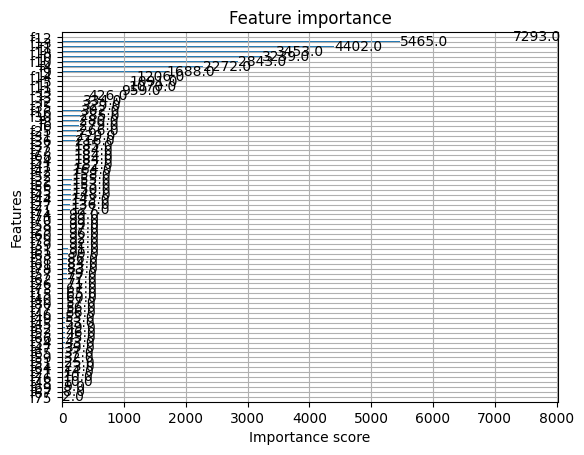

In [56]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

In [59]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [10, 100]
}

grid = GridSearchCV(xgb_model, param_grid, cv=3, scoring='f1_macro')
grid.fit(X_train_clean.values, y_train.values)

print("Mejores parámetros:", grid.best_params_)

KeyboardInterrupt: 